## 为什么交叉熵（cross-entropy）损失函数优于均方差损失函数？


对于分类损失函数而言，我们经常选取交叉熵损失函数，而非均方差损失函数（虽然存在像[YOLO v1](https://arxiv.org/abs/1506.02640)这种使用均方差损失函数的论文，但毕竟是个例）。但我们为什么觉得，交叉熵损失函数要优于均方差损失函数呢？

---

### 损失函数

交叉熵损失函数公式 及其 导数 为：

$$
\begin{eqnarray}
& \mathcal{L}_{crossentropy} & = & - \sum_{i} (y_{i} * log(\hat{y}_{i})) \\
& \frac{\partial{\mathcal{L}_{crossentropy}}}{\partial{\hat{y}_{i}}} & = & - \frac{y_{i}}{\hat{y}_{i}}
\end{eqnarray}
$$


均方差损失函数 及其 导数 为：
$$
\begin{eqnarray}
& \mathcal{L}_{mse} & = & \frac{1}{2} \sum_{i} (y_{i} - \hat{y}_{i})^2 \\
& \frac{\partial{\mathcal{L}_{mse}}}{\partial{\hat{y}_{i}}} & = & - (y_{i} - \hat{y}_{i})
\end{eqnarray}
$$

画出两者的曲线对比可以看出，**交叉熵损失函数提供更大的损失和梯度，在预测误差增大时更甚！**同时，就算预测正确，交叉熵损失函数研究提供梯度不断优化。

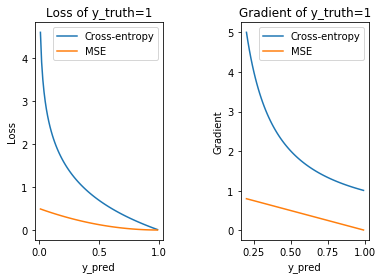

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

epsilon = 1e-15
y_truth = 1
plt.subplots_adjust(wspace=0.6, hspace=0.6)
# 损失函数（针对二分类情况）
y_pred = np.arange(0.01, 1-epsilon, 1e-2)
cross_entropy_loss = - y_truth * np.log(y_pred)
mse_loss = np.power(1 - y_pred, 2) / 2
plt.subplot(1, 2, 1)
plt.plot(y_pred, cross_entropy_loss, label="Cross-entropy")
plt.plot(y_pred, mse_loss, label="MSE")
plt.title("Loss of y_truth=1")
plt.xlabel("y_pred")
plt.ylabel("Loss")
plt.legend()
# 梯度(取反)
y_pred = np.arange(0.2, 1-epsilon, 1e-2)
cross_entropy_gradient = y_truth / y_pred
mse_gradient = y_truth - y_pred
plt.subplot(1, 2, 2)
plt.plot(y_pred, cross_entropy_gradient, label="Cross-entropy")
plt.plot(y_pred, mse_gradient, label="MSE")
plt.title("Gradient of y_truth=1")
plt.xlabel("y_pred")
plt.ylabel("Gradient")
plt.legend()
plt.show()

### 分类损失函数的输入——Softmax函数

一般分类损失函数的输入是Sigmoid函数或者Softmax函数的输出，Sigmoid函数可以看成Softmax函数的退化为二分类的情况。

我这里就单讨论Softmax函数及其导数：
$$
\begin{eqnarray}
& \hat{y}_{i} & =  & Softmax(z_{i}) = \frac{e^{z_{i}}}{\sum_{j}e^{z_{j}}}, z_{i}=w_{i}x \\
& \frac{\partial{\hat{y}_{i}}}{\partial{z_{j}}} & = &
\left\{\begin{matrix}
& \hat{y}_{i} * (1 - \hat{y}_{i}), & j=i \\
& - \hat{y}_{i}*\hat{y}_{j}, & j \not=i
\end{matrix} \right.
\end{eqnarray}
$$

画出Sigmoid梯度图，可以看出，**梯度随着激活值呈现出上升然后下降的过程。**这是一个主要的差异点，一般函数的梯度会随着误差的增大单调增。而Softmax的这个反常特性正是经常选择交叉熵作为损失函数的原因所在。请看下部分分析。

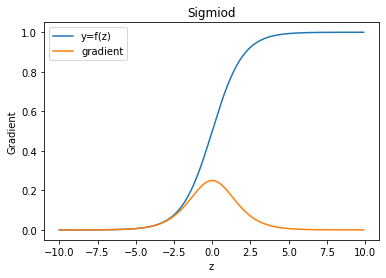

In [50]:
%matplotlib inline
z = np.arange(-10, 10, 1e-1)
sigmoid = 1 / (1 + np.exp(-z))
sigmiod_gradient = sigmoid * (1 - sigmoid)
plt.plot(z, sigmoid, label="y=f(z)")
plt.plot(z, sigmiod_gradient, label="gradient")
plt.title("Sigmiod")
plt.xlabel("z")
plt.ylabel("Gradient")
plt.legend()
plt.show()

### 损失函数与Softmax函数的结合


交叉熵损失函数公式 及其 导数 为：

$$
\begin{eqnarray}
& \mathcal{L}_{crossentropy} & = & - \sum_{i} (y_{i} * log(\frac{e^{z_{i}}}{\sum_{j}e^{z_{j}}})) \\
& \frac{\partial{\mathcal{L}_{crossentropy}}}{\partial{z_{k}}} & = & 
 - [\frac{y_{k}}{\hat{y}_{k}} * \hat{y}_{k} * (1 - \hat{y}_{k}) - \sum_{i\not=k} (\frac{y_{i}}{\hat{y}_{i}} * \hat{y}_{i}*\hat{y}_{k})] \\
& & = & - [y_{k} * (1 - \hat{y}_{k}) - \sum_{i\not=k} (y_{i}*\hat{y}_{k})] \\
& & = & 
\left\{\begin{matrix}
& - (1 - \hat{y}_{k}), & y_{k}=1 \\
& \hat{y}_{k}, & y_{k}=0
\end{matrix} \right.
\end{eqnarray}
$$


均方差损失函数 及其 导数 为：

$$
\begin{eqnarray}
& \mathcal{L}_{mse} & = & \frac{1}{2} \sum_{i} (y_{i} -\frac{e^{z_{i}}}{\sum_{j}e^{z_{j}}})^2 \\
& \frac{\partial{\mathcal{L}_{mse}}}{\partial{z_{k}}} &
= & - [(y_{k} - \hat{y}_{k}) * \hat{y}_{k} * (1 - \hat{y}_{k}) - \sum_{i\not=k}[(y_{i} - \hat{y}_{i}) * \hat{y}_{i}*\hat{y}_{k}]] \\
& & = & -
\left\{\begin{matrix}
& \hat{y}_{k} * (1 - \hat{y}_{k})^{2} - \sum_{i\not=k}[ - \hat{y}^{2}_{i}*\hat{y}_{k}], & y_{k}=1 \\
&  - \hat{y}^{2}_{k} * (1 - \hat{y}_{k}) - [(1 - \hat{y}_{j}) * \hat{y}_{j}*\hat{y}_{k}] - \sum_{i\notin {k,j}}[ - \hat{y}^{2}_{i}*\hat{y}_{k}], & y_{j}=1
\end{matrix} \right.
\end{eqnarray}
$$

第二部分已经看出了Softmax函数梯度的“异常”了，而下图可以看出，**MSE损失函数延续了该“异常”（峰值不是0了，左移了一点），而CE损失函数则通过CE梯度中的$\frac{1}{\hat{y}_{i}}$项去除了该“异常”（上式求导公式也可以看出来）。**


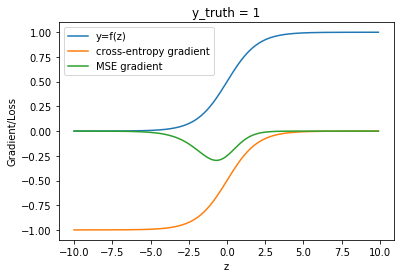

In [53]:
%matplotlib inline
# 假设只有二分类
y_truth = 1
z = np.arange(-10, 10, 1e-1)
sigmoid = 1 / (1 + np.exp(-z))
cross_entropy_gradient = - (1 - sigmoid)
mse_gradient = - (sigmoid * np.power((1 - sigmoid), 2) + np.power((1 - sigmoid), 2) * sigmoid)
plt.plot(z, sigmoid, label="y=f(z)")
plt.plot(z, cross_entropy_gradient, label="cross-entropy gradient")
plt.plot(z, mse_gradient, label="MSE gradient")
plt.title("y_truth = 1")
plt.xlabel("z")
plt.ylabel("Gradient/Loss")
plt.legend()
plt.show()

### 总结

由以上分析可以看出，用CE函数作为以Softmax函数输入的损失函数，实现了梯度随误差增加单调增的良好特性。而“反逻辑”的想，均方误差损失函数，是不是可能有利于免疫异常数据的影响？

或者说在前期使用CE几个epoches学习到正常的样本，后期用MSE进一步学习尚有良好信息的样本，而舍弃不良样本？